In [1]:
import pandas as pd
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

In [2]:
df = pd.read_csv("transformed_radiological_gradings_updated.csv")

In [3]:
image_folder = "all_images"

In [4]:
image_list = []
label_list = []

for image_filename in os.listdir(image_folder):
    if image_filename.endswith(".png"):
        patient_id = int(image_filename.split('_')[0])
        patient_row = df[df['Patient'] == patient_id]
        image = Image.open(os.path.join(image_folder, image_filename))

        # Resize image to 224x224 pixels
        image_resized = image.resize((224,224))

        # Convert image to RGB
        image_recolored = image_resized.convert("RGB")

        # Convert the image to numpy array
        image_array = np.array(image_recolored)

        # Normalize array
        image_array_normalized = image_array / 255.0

        # Normalize for ImageNet
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_array_normalized = (image_array_normalized - mean[None, None, :]) / std[None, None, :]

        image_list.append(img_array_normalized)
        labels = patient_row.iloc[0].values[1:]
        label_list.append(labels)
        
        # print(f"Image: {image_filename}, Patient Data: {labels}")

image_list_np = np.array(image_list)

In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

In [7]:
herniation_output = Dense(1, activation='sigmoid', name='disc_herniation')(x)
narrowing_output = Dense(1, activation='sigmoid', name='disc_narrowing')(x)
bulging_output = Dense(1, activation='sigmoid', name='disc_bulging')(x)
#modic_output = Dense(4, activation='softmax', name='modic_type')(x)
pfirrman_output = Dense(1, activation='linear', name='pfirrman_grade')(x)
up_endplate_output = Dense(1, activation='sigmoid', name='up_endplate')(x)
low_endplate_output = Dense(1, activation='sigmoid', name='low_endplate')(x)
spondylolisthesis_output = Dense(1, activation='sigmoid', name='spondylolisthesis')(x)

In [8]:
model = Model(inputs=base_model.input, outputs=[
    herniation_output,
    narrowing_output,
    bulging_output,
    #modic_output,
    pfirrman_output,
    up_endplate_output,
    low_endplate_output,
    spondylolisthesis_output
])

In [9]:
model.compile(
    optimizer='adam',
    loss={
        'disc_herniation': 'binary_crossentropy',
        'disc_narrowing': 'binary_crossentropy',
        'disc_bulging': 'binary_crossentropy',
        #'modic_type': 'sparse_categorical_crossentropy',
        'pfirrman_grade': 'mean_squared_error',
        'up_endplate': 'binary_crossentropy',
        'low_endplate': 'binary_crossentropy',
        'spondylolisthesis': 'binary_crossentropy'
    },
    metrics={
        'disc_herniation': 'accuracy',
        'disc_narrowing': 'accuracy',
        'disc_bulging': 'accuracy',
        #'modic_type': 'accuracy',
        'pfirrman_grade': 'mae',
        'up_endplate': 'accuracy',
        'low_endplate': 'accuracy',
        'spondylolisthesis': 'accuracy'
    }
)

In [10]:
modic_labels = [row[0] for row in label_list]
up_endplate_labels = [row[1] for row in label_list]
low_endplate_labels = [row[2] for row in label_list]
spondylolisthesis_labels = [row[3] for row in label_list]
herniation_labels = [row[4] for row in label_list]
narrowing_labels = [row[5] for row in label_list]
bulging_labels = [row[6] for row in label_list]
pfirrman_labels = [row[7] for row in label_list]

In [11]:
modic_labels_one_hot = to_categorical(modic_labels, num_classes=4)

In [12]:
print("First Image Shape:", image_list[0].shape)
print("Modic Labels (One-Hot):", modic_labels_one_hot[0])
print("UP Endplate Label:", up_endplate_labels[0])
print("LOW Endplate Label:", low_endplate_labels[0])
print("Spondylolisthesis Label:", spondylolisthesis_labels[0])
print("Disc Herniation Label:", herniation_labels[0])
print("Disc Narrowing Label:", narrowing_labels[0])
print("Disc Bulging Label:", bulging_labels[0])
print("Pfirmann Label:", pfirrman_labels[0])

First Image Shape: (224, 224, 3)
Modic Labels (One-Hot): [0. 0. 1. 0.]
UP Endplate Label: 1.0
LOW Endplate Label: 1.0
Spondylolisthesis Label: 0.0
Disc Herniation Label: 0.0
Disc Narrowing Label: 1.0
Disc Bulging Label: 1.0
Pfirmann Label: 2.5


In [13]:
label_dict = {
    'disc_herniation': np.array(herniation_labels),
    'disc_narrowing': np.array(narrowing_labels),
    'disc_bulging': np.array(bulging_labels),
    'pfirrman_grade': np.array(pfirrman_labels),
    'up_endplate': np.array(up_endplate_labels),
    'low_endplate': np.array(low_endplate_labels),
    'spondylolisthesis': np.array(spondylolisthesis_labels),
    #'modic_type': np.array(modic_labels_one_hot)
}

In [15]:
history = model.fit(
    image_list_np, label_dict,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - disc_bulging_accuracy: 0.7702 - disc_bulging_loss: 0.5186 - disc_herniation_accuracy: 0.4311 - disc_herniation_loss: 0.5412 - disc_narrowing_accuracy: 0.3196 - disc_narrowing_loss: 0.6987 - loss: 13.0200 - low_endplate_accuracy: 0.2324 - low_endplate_loss: 0.5467 - pfirrman_grade_loss: 5.2346 - pfirrman_grade_mae: 2.6699 - spondylolisthesis_accuracy: 0.3719 - spondylolisthesis_loss: 0.6561 - up_endplate_accuracy: 0.7173 - up_endplate_loss: 4.8241 - val_disc_bulging_accuracy: 0.9315 - val_disc_bulging_loss: 20.8368 - val_disc_herniation_accuracy: 0.2603 - val_disc_herniation_loss: 17.0728 - val_disc_narrowing_accuracy: 0.1233 - val_disc_narrowing_loss: 12.1908 - val_loss: 94.0794 - val_low_endplate_accuracy: 0.1370 - val_low_endplate_loss: 4.7369 - val_pfirrman_grade_loss: 14.4391 - val_pfirrman_grade_mae: 888.2497 - val_spondylolisthesis_accuracy: 0.1781 - val_spondylolisthesis_loss: 21.6017 - val_up_endplate_accuracy: 0.7808 - val_up_e

In [ ]:
print(image_list_np.shape)
print(np.array(modic_labels_one_hot).shape)

In [ ]:
for key, value in label_dict.items():
    print(f"{key} Shape:", np.array(value).shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.6399999999999997].


(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
(7, 1, 1)


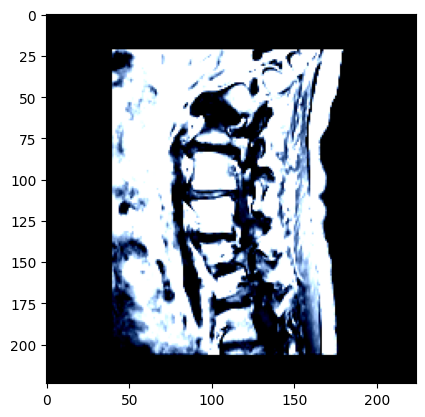

In [27]:
test_img_folder = 'all_images'
image = Image.open(os.path.join(test_img_folder, '1_t1.png'))

# Resize image to 224x224 pixels
image_resized = image.resize((224,224))

# Convert image to RGB
image_recolored = image_resized.convert("RGB")

# Convert the image to numpy array
image_array = np.array(image_recolored)

# Normalize array
image_array_normalized = image_array / 255.0

# Normalize for ImageNet
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_array_normalized = (image_array_normalized - mean[None, None, :]) / std[None, None, :]
plt.imshow(img_array_normalized)
img_array_normalized = np.expand_dims(img_array_normalized, 0)
print(img_array_normalized.shape)


predictions = model.predict(img_array_normalized)
np_version = np.array(predictions)
print(np_version.shape)
# [disc_herniation_predictions, disc_narrowing_predictions, disc_bulging_predictions, modic_type_predictions, pfirrman_grade_predictions, up_endplate_predictions, low_endplate_predictions, spondylolisthesis_predictions]

In [28]:
print("Disc Herniation: ")
print(predictions[0][0][0])
print("Disc Narrowing: ")
print(predictions[1][0][0])
print("Disc Bulging: ")
print(predictions[2][0][0])
print("Pfirmann Grade: ")
print(predictions[3][0][0])
print("Up-Endplate: ")
print(predictions[4][0][0])
print("Low-Endplate: ")
print(predictions[5][0][0])
print("Spondylo: ")
print(predictions[6][0][0])


Disc Herniation: 
1.0
Disc Narrowing: 
0.0
Disc Bulging: 
9.5909405e-37
Pfirmann Grade: 
2.477459716796875
Up-Endplate: 
1.0
Low-Endplate: 
0.0
Spondylo: 
1.0


In [26]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 70,699,927 (269.70 MB)

 Trainable params: 23,548,935 (89.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,097,872 (179.66 MB)